In [1]:
# Import needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import pickle
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn.linear_model as lmm
#ensembling
from mlxtend.classifier import StackingCVClassifier

#EDA
from collections import Counter
#import pandas_profiling as pp

from plotly.offline import iplot
import plotly as py
import plotly.tools as tls

from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
os.getcwd()

'/Users/arvindprashanth'

In [3]:
import csv
import sqlite3
import pandas as pd

# Step 1: Parse the CSV data
csv_file_path = 'heart.csv'  # Replace with your CSV file path
data = []

with open('heart.csv', 'r') as file:
    file.readline()  # Skip the header row
    for line in file:
        row = line.strip().split(',')  # Assuming CSV format, modify delimiter if necessary
        data.append(row)

# Step 2: Load the data into an in-memory SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Create tables
cursor.execute('CREATE TABLE id_age_sex (id INTEGER PRIMARY KEY AUTOINCREMENT, age INTEGER, sex INTEGER)')
cursor.execute('CREATE TABLE clinical (id INTEGER PRIMARY KEY AUTOINCREMENT, cp INTEGER, trestbps INTEGER, chol INTEGER, fbs INTEGER, restecg INTEGER, thalach INTEGER, FOREIGN KEY(id) REFERENCES id_age_sex(id))')
cursor.execute('CREATE TABLE diagnostic (id INTEGER PRIMARY KEY AUTOINCREMENT, exang INTEGER, oldpeak INTEGER, slope INTEGER, ca INTEGER, thal INTEGER, target INTEGER, FOREIGN KEY(id) REFERENCES id_age_sex(id))')
cursor.execute('CREATE TABLE heart (id INTEGER PRIMARY KEY AUTOINCREMENT, age INTEGER, sex INTEGER, cp INTEGER, trestbps INTEGER, chol INTEGER, fbs INTEGER, restecg INTEGER, thalach INTEGER, exang INTEGER, oldpeak INTEGER, slope INTEGER, ca INTEGER, thal INTEGER, target INTEGER)')
# Assuming 'age' and 'sex' are the second and third columns in the CSV
for row in data:
    id_age_sex = (row[0], row[1])
    clinical = (row[2], row[3], row[4], row[5], row[6], row[7])
    diagnostic = (row[8], row[9], row[10], row[11], row[12], row[13])
    heart_i = (row[0], row[1],row[2], row[3], row[4], row[5], row[6], row[7],row[8], row[9], row[10], row[11], row[12], row[13])

    cursor.execute('INSERT INTO id_age_sex (age, sex) VALUES (?, ?)', id_age_sex)
    last_id = cursor.lastrowid  # Get the last inserted ID

    clinical_with_id = (last_id,) + clinical
    diagnostic_with_id = (last_id,) + diagnostic
    heart_i1=(last_id,) + heart_i

    cursor.execute('INSERT INTO clinical (id, cp, trestbps, chol, fbs, restecg, thalach) VALUES (?, ?, ?, ?, ?, ?, ?)', clinical_with_id)
    cursor.execute('INSERT INTO diagnostic (id, exang, oldpeak, slope, ca, thal, target) VALUES (?, ?, ?, ?, ?, ?, ?)', diagnostic_with_id)
    cursor.execute('INSERT INTO heart (id, age, sex, cp, trestbps, chol, fbs, restecg, thalach,exang, oldpeak, slope, ca, thal, target) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', heart_i1)

conn.commit()

# Step 3: Perform SQL joins and load the data into Pandas for analysis
query = '''
SELECT
    id_age_sex.id,
    id_age_sex.age,
    id_age_sex.sex,
    clinical.cp,
    clinical.trestbps,
    clinical.chol,
    clinical.fbs,
    clinical.restecg,
    clinical.thalach,
    diagnostic.exang,
    diagnostic.oldpeak,
    diagnostic.slope,
    diagnostic.ca,
    diagnostic.thal,
    diagnostic.target
FROM id_age_sex
LEFT JOIN clinical ON id_age_sex.id = clinical.id
LEFT JOIN diagnostic ON id_age_sex.id = diagnostic.id
'''

df = pd.read_sql_query(query, conn)

# Now, display summary statistics
print(df.describe())
#conn.commit()
# Close the connection to the database
#conn.close()

               id         age         sex          cp    trestbps        chol  \
count  301.000000  301.000000  301.000000  301.000000  301.000000  301.000000   
mean   151.000000   54.378738    0.684385    0.966777  131.647841  246.504983   
std     87.035433    9.110950    0.465534    1.032259   17.594002   51.915998   
min      1.000000   29.000000    0.000000    0.000000   94.000000  126.000000   
25%     76.000000   47.000000    0.000000    0.000000  120.000000  211.000000   
50%    151.000000   56.000000    1.000000    1.000000  130.000000  241.000000   
75%    226.000000   61.000000    1.000000    2.000000  140.000000  275.000000   
max    301.000000   77.000000    1.000000    3.000000  200.000000  564.000000   

              fbs     restecg     thalach       exang     oldpeak       slope  \
count  301.000000  301.000000  301.000000  301.000000  301.000000  301.000000   
mean     0.146179    0.528239  149.740864    0.325581    1.043189    1.398671   
std      0.353874    0.5260

**1. Data Preparation and Data Exploration**

---

In [4]:
# Read data
# Modify this query for your analysis needs

sql_query = "SELECT * FROM heart"
df = pd.read_sql_query(sql_query, conn)
df.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,2,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,3,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,4,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,5,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.shape

(301, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        301 non-null    int64  
 1   age       301 non-null    int64  
 2   sex       301 non-null    int64  
 3   cp        301 non-null    int64  
 4   trestbps  301 non-null    int64  
 5   chol      301 non-null    int64  
 6   fbs       301 non-null    int64  
 7   restecg   301 non-null    int64  
 8   thalach   301 non-null    int64  
 9   exang     301 non-null    int64  
 10  oldpeak   301 non-null    float64
 11  slope     301 non-null    int64  
 12  ca        301 non-null    int64  
 13  thal      301 non-null    int64  
 14  target    301 non-null    int64  
dtypes: float64(1), int64(14)
memory usage: 35.4 KB


In [7]:
df.describe(include='all')

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,151.000000,54.378738,0.684385,0.966777,131.647841,246.504983,0.146179,0.528239,149.740864,0.325581,1.043189,1.398671,0.734219,2.328904,0.544850
std,87.035433,9.110950,0.465534,1.032259,17.594002,51.915998,0.353874,0.526023,22.891031,0.469372,1.163384,0.616872,1.024268,0.584347,0.498814
min,1.000000,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,76.000000,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,134.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,151.000000,56.000000,1.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,226.000000,61.000000,1.000000,2.000000,140.000000,275.000000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,301.000000,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [8]:
#Check null values
df.isnull().sum()

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
df['target'].value_counts()

target
1    164
0    137
Name: count, dtype: int64

In [10]:
# Percentage of patients have and do not have heart disease
df['target'].value_counts()/df.shape[0]*100

target
1    54.48505
0    45.51495
Name: count, dtype: float64

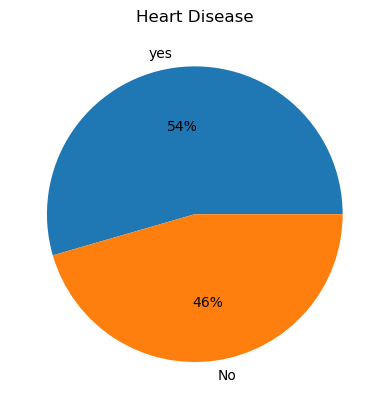

In [11]:
# Create a plot to display the percentage of the positive and negative heart disease
labels = ['yes', 'No']
values = df['target'].value_counts().values

plt.pie(values, labels=labels, autopct='%1.0f%%')
plt.title('Heart Disease')
plt.show()

Attributes Correlation

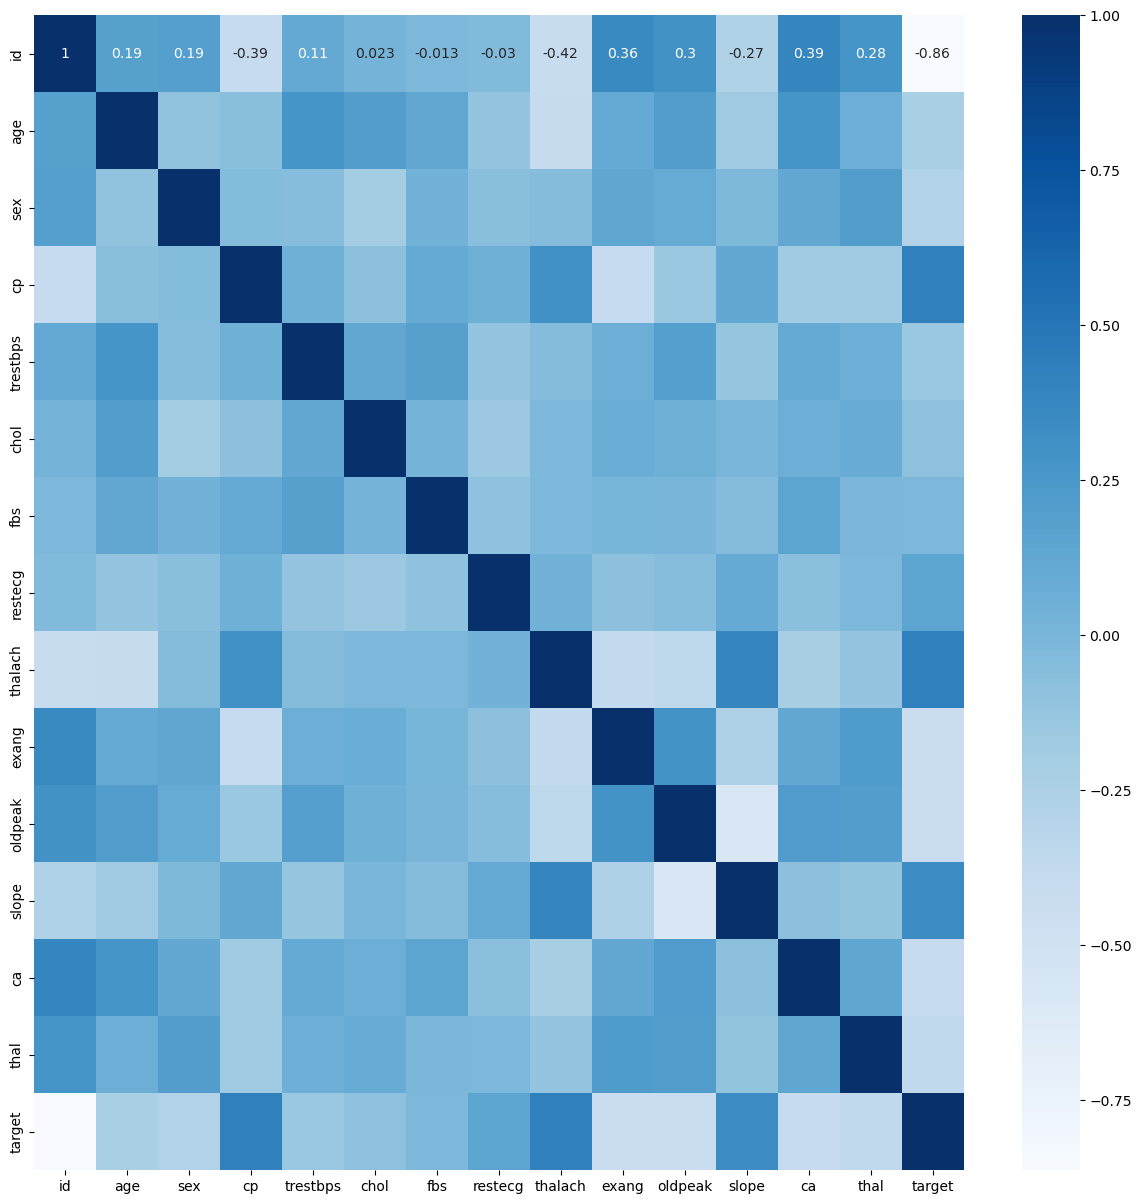

In [12]:
# Correlation map
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot = True, cmap = "Blues")
plt.show()

Age Exploration

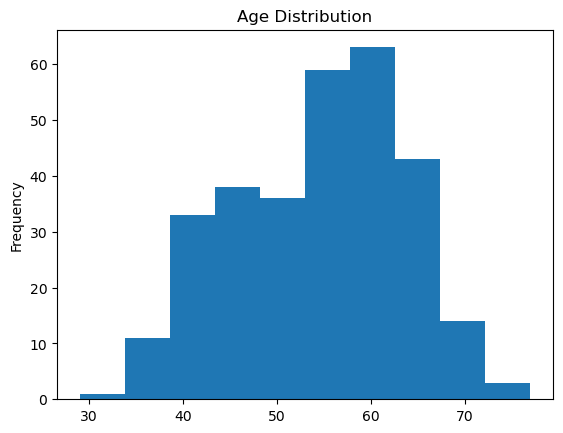

In [13]:
# Display age distribution
df['age'].plot(kind = 'hist', title = 'Age Distribution')
plt.show()

In [14]:
# Get min, max and average of the age
print('Min age: ', min(df['age']))
print('Max age: ', max(df['age']))
print('Average age: ', df['age'].mean())

Min age:  29
Max age:  77
Average age:  54.37873754152824


/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/1400829893.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/1400829893.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-leve

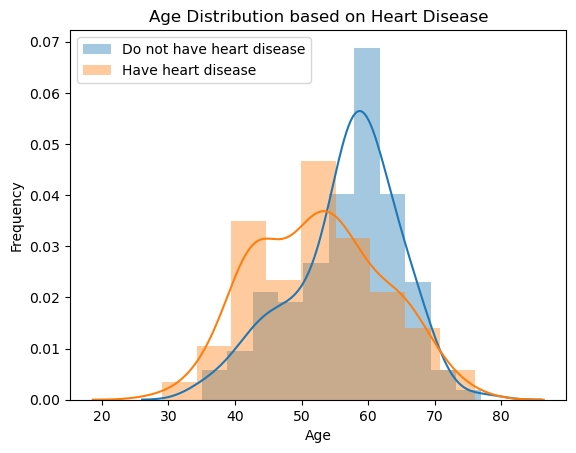

In [15]:
# Display age distribution based on heart disease
sns.distplot(df[df['target'] == 0]['age'], label='Do not have heart disease')
sns.distplot(df[df['target'] == 1]['age'], label = 'Have heart disease')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution based on Heart Disease')
plt.legend()
plt.show()

In [16]:
# Get min, max and average of the age of the people do not have heart disease
print('Min age of people who do not have heart disease: ', min(df[df['target'] == 0]['age']))
print('Max age of people who do not have heart disease: ', max(df[df['target'] == 0]['age']))
print('Average age of people who do not have heart disease: ', df[df['target'] == 0]['age'].mean())

Min age of people who do not have heart disease:  35
Max age of people who do not have heart disease:  77
Average age of people who do not have heart disease:  56.63503649635037


In [17]:
# Get min, max and average of the age of the people have heart diseas
print('Min age of people who have heart disease: ', min(df[df['target'] == 1]['age']))
print('Max age of people who have heart disease: ', max(df[df['target'] == 1]['age']))
print('Average age of people who have heart disease: ', df[df['target'] == 1]['age'].mean())

Min age of people who have heart disease:  29
Max age of people who have heart disease:  76
Average age of people who have heart disease:  52.49390243902439


Gender Exploration

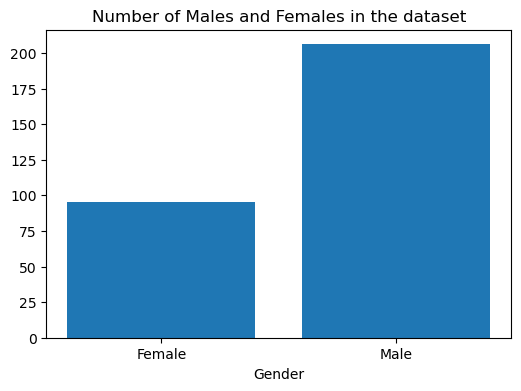

In [18]:
# Number of males and females
F = df[df['sex'] == 0].count()['target']
M = df[df['sex'] == 1].count()['target']

# Create a plot
figure, ax = plt.subplots(figsize = (6, 4))
ax.bar(x = ['Female', 'Male'], height = [F, M])
plt.xlabel('Gender')
plt.title('Number of Males and Females in the dataset')
plt.show()

Chest Pain Type Exploration

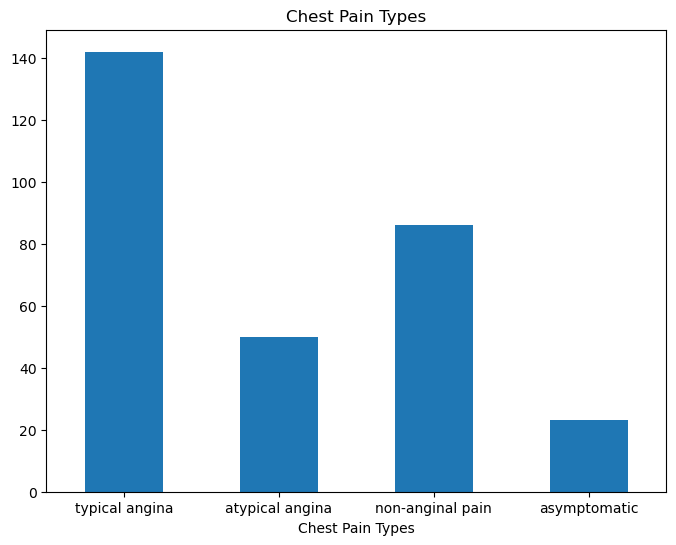

In [19]:
# Display chest pain types in bar chart
df.groupby(df['cp']).count()['target'].plot(kind = 'bar', title = 'Chest Pain Types', figsize = (8, 6))
plt.xlabel('Chest Pain Types')
plt.xticks(np.arange(4), ('typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'), rotation = 0)
plt.show()

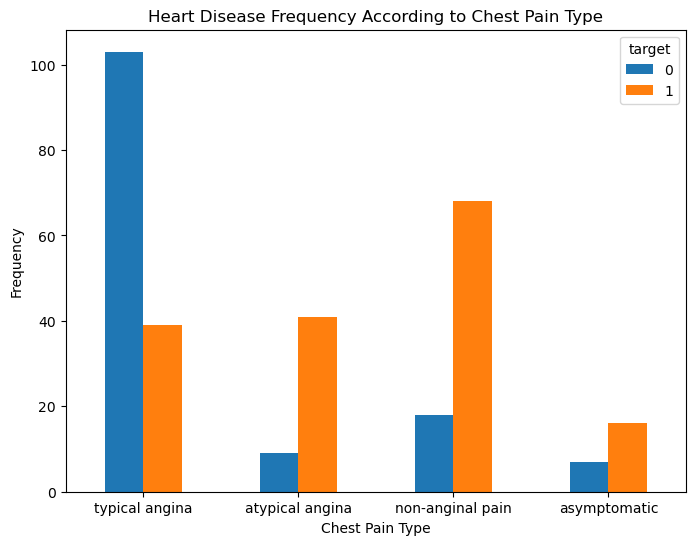

In [20]:
# Display chest pain types based on the target
pd.crosstab(df.cp,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(np.arange(4), ('typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

Blood Pressure Exploration

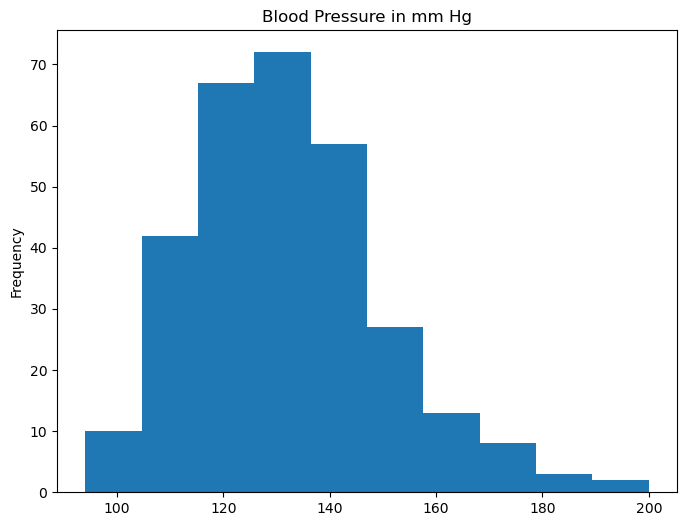

In [21]:
# Display blood pressure distribution
df['trestbps'].plot(kind = 'hist', title = 'Blood Pressure in mm Hg', figsize = (8, 6))
plt.show()

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/2304381456.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/2304381456.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-leve

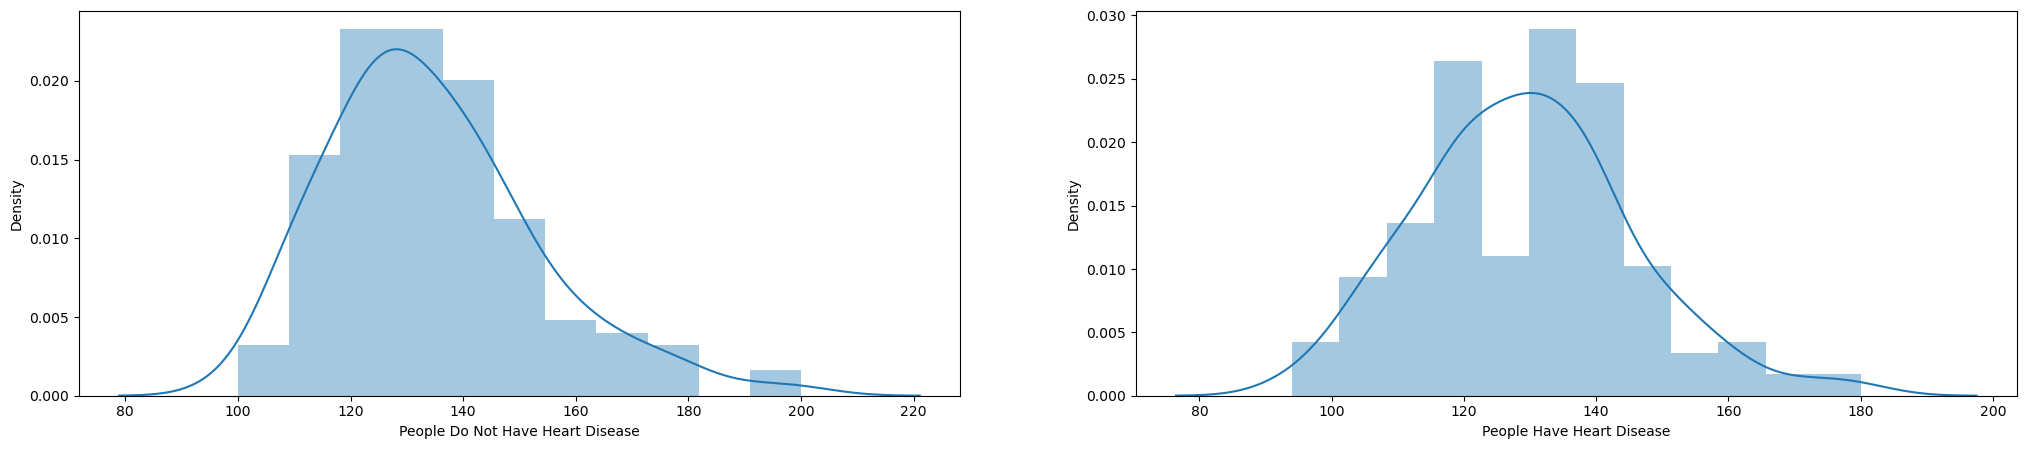

In [22]:
# Display blood pressure distribution based on heart disease
fig, (axis1, axis2) = plt.subplots(1, 2,figsize=(25, 5))
ax = sns.distplot(df[df['target'] == 0]['trestbps'], label='Do not have heart disease', ax = axis1)
ax.set(xlabel='People Do Not Have Heart Disease')
ax = sns.distplot(df[df['target'] == 1]['trestbps'], label = 'Have heart disease', ax = axis2)
ax.set(xlabel='People Have Heart Disease')
plt.show()

In [23]:
# Get min, max and average of the  blood pressure of the people do not have heart diseas
print('Min blood pressure of people who do not have heart disease: ', min(df[df['target'] == 0]['trestbps']))
print('Max blood pressure of people who do not have heart disease: ', max(df[df['target'] == 0]['trestbps']))
print('Average blood pressure of people who do not have heart disease: ', df[df['target'] == 0]['trestbps'].mean())

Min blood pressure of people who do not have heart disease:  100
Max blood pressure of people who do not have heart disease:  200
Average blood pressure of people who do not have heart disease:  134.44525547445255


In [24]:
# Get min, max and average of the blood pressure of the people have heart diseas
print('Min blood pressure of people who have heart disease: ', min(df[df['target'] == 1]['trestbps']))
print('Max blood pressure of people who have heart disease: ', max(df[df['target'] == 1]['trestbps']))
print('Average blood pressure of people who have heart disease: ', df[df['target'] == 1]['trestbps'].mean())

Min blood pressure of people who have heart disease:  94
Max blood pressure of people who have heart disease:  180
Average blood pressure of people who have heart disease:  129.3109756097561


Cholestoral Exploration

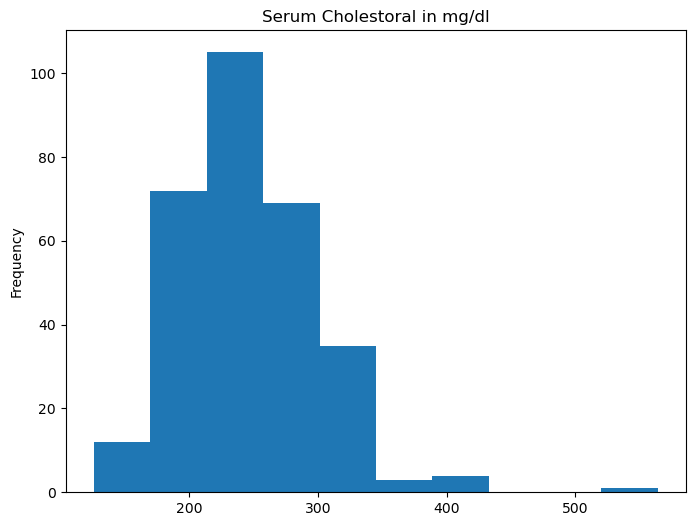

In [25]:
# Display Cholestoral distribution
df['chol'].plot(kind = 'hist', title = 'Serum Cholestoral in mg/dl', figsize = (8, 6))
plt.show()

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/3267733427.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/3267733427.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-leve

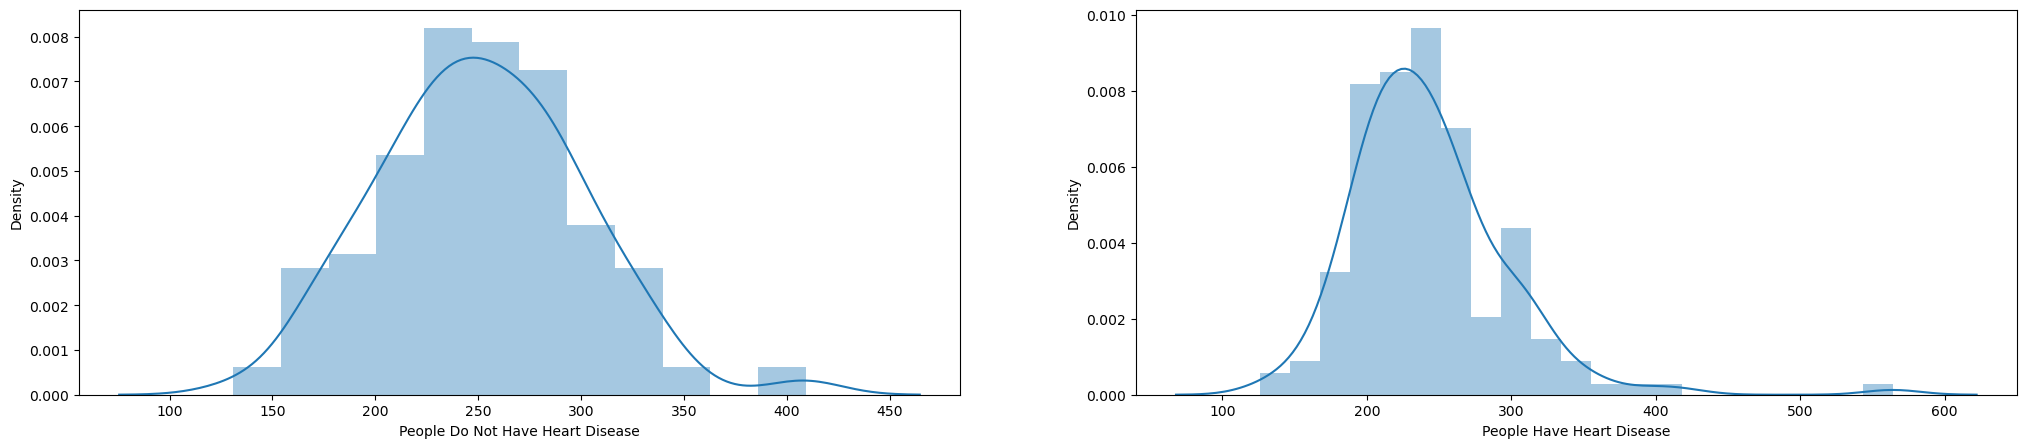

In [26]:
# Display Cholestoral distribution based on heart disease
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(25, 5))
ax = sns.distplot(df[df['target'] == 0]['chol'], label='Do not have heart disease', ax = axis1)
ax.set(xlabel='People Do Not Have Heart Disease')
ax = sns.distplot(df[df['target'] == 1]['chol'], label = 'Have heart disease', ax = axis2)
ax.set(xlabel='People Have Heart Disease')
plt.show()

In [27]:
# Get min, max and average of the Cholestoral of the people do not have heart diseas
print('Min cholestoral of people who do not have heart disease: ', min(df[df['target'] == 0]['chol']))
print('Max cholestoral of people who do not have heart disease: ', max(df[df['target'] == 0]['chol']))
print('Average cholestoral of people who do not have heart disease: ', df[df['target'] == 0]['chol'].mean())

Min cholestoral of people who do not have heart disease:  131
Max cholestoral of people who do not have heart disease:  409
Average cholestoral of people who do not have heart disease:  251.43065693430657


In [28]:
# Get min, max and average of the Cholestoral of the people have heart diseas
print('Min cholestoral of people who have heart disease: ', min(df[df['target'] == 1]['chol']))
print('Max cholestoral of people who have heart disease: ', max(df[df['target'] == 1]['chol']))
print('Average cholestorale of people who have heart disease: ', df[df['target'] == 1]['chol'].mean())

Min cholestoral of people who have heart disease:  126
Max cholestoral of people who have heart disease:  564
Average cholestorale of people who have heart disease:  242.390243902439


Fasting Blood Sugar Exploration

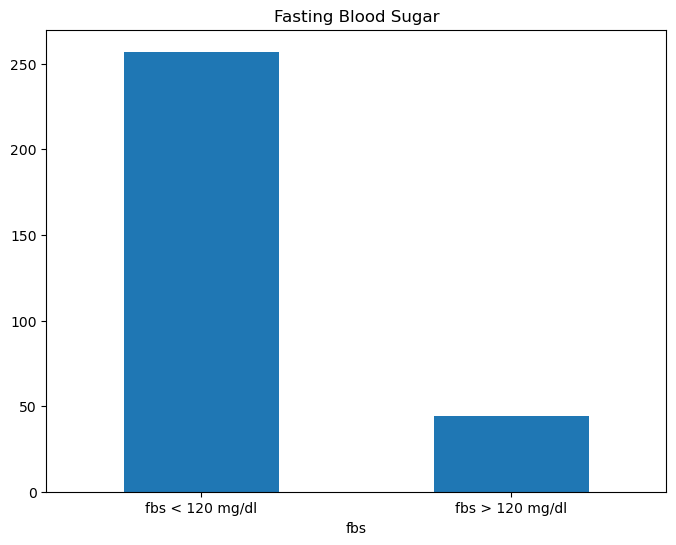

In [29]:
# Display fasting blood sugar in bar chart
df.groupby(df['fbs']).count()['target'].plot(kind = 'bar', title = 'Fasting Blood Sugar', figsize = (8, 6))
plt.xticks(np.arange(2), ('fbs < 120 mg/dl', 'fbs > 120 mg/dl'), rotation = 0)
plt.show()

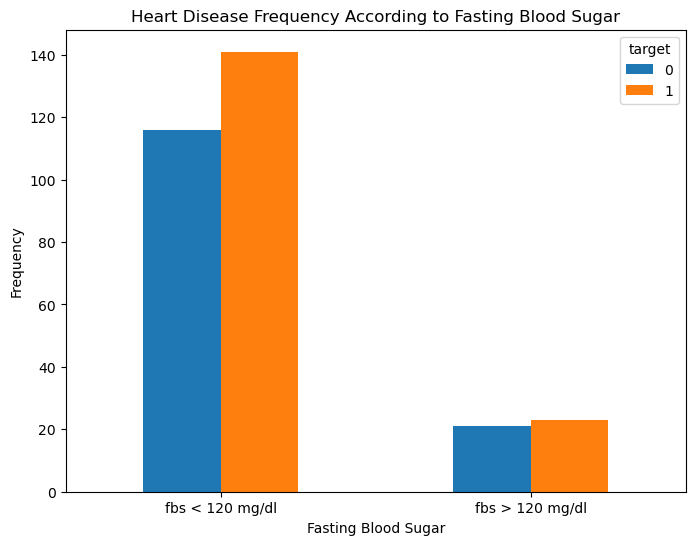

In [30]:
# Display fasting blood sugar based on the target
pd.crosstab(df.fbs,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Fasting Blood Sugar')
plt.xlabel('Fasting Blood Sugar')
plt.xticks(np.arange(2), ('fbs < 120 mg/dl', 'fbs > 120 mg/dl'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

Electrocardiographic Results Exploration

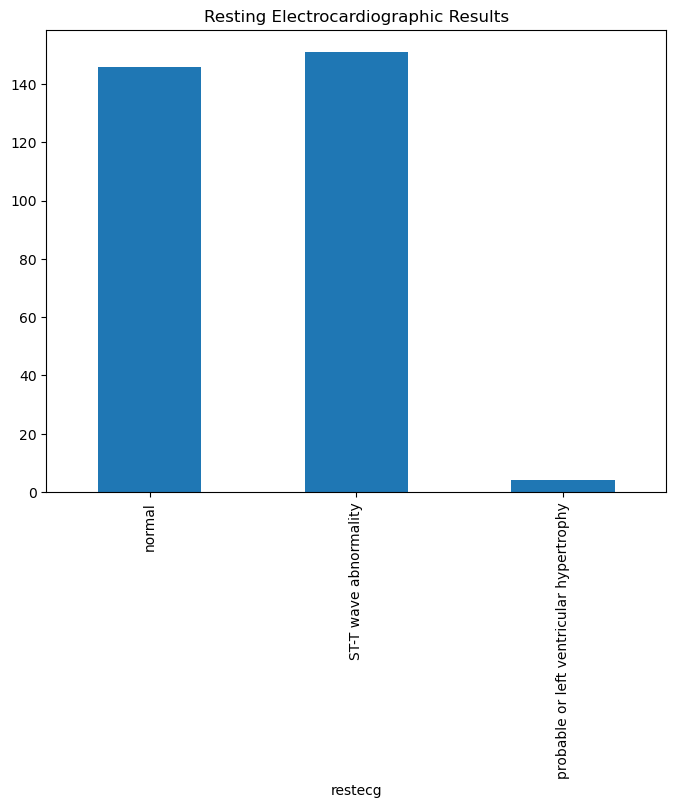

In [31]:
# Display electrocardiographic results in bar chart
df.groupby(df['restecg']).count()['target'].plot(kind = 'bar', title = 'Resting Electrocardiographic Results', figsize = (8, 6))
plt.xticks(np.arange(3), ('normal', 'ST-T wave abnormality', 'probable or left ventricular hypertrophy'))
plt.show()

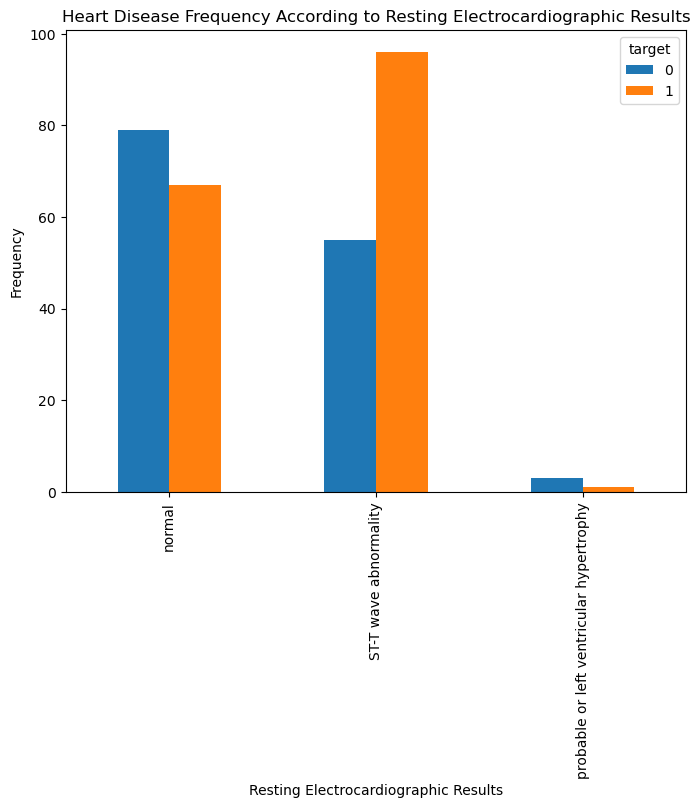

In [32]:
# Display resting electrocardiographic results based on the target
pd.crosstab(df.restecg,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Resting Electrocardiographic Results')
plt.xticks(np.arange(3), ('normal', 'ST-T wave abnormality', 'probable or left ventricular hypertrophy'))
plt.xlabel('Resting Electrocardiographic Results')
plt.ylabel('Frequency')
plt.show()

Maximum Heart Rate Exploration

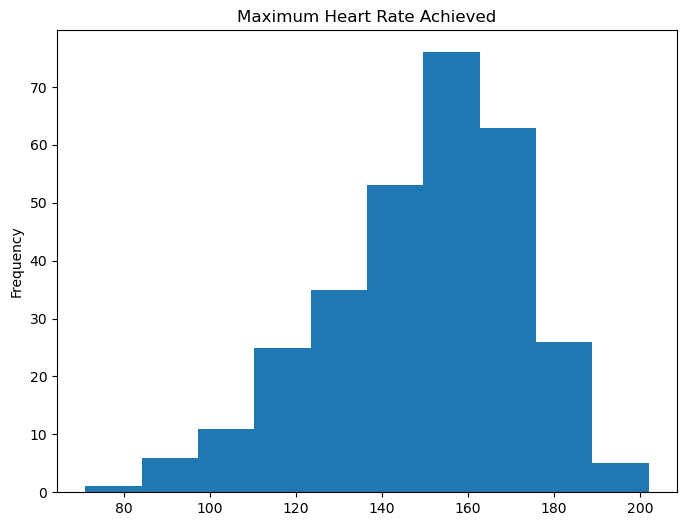

In [33]:
# Display maximum heart rate distribution
df['thalach'].plot(kind = 'hist', title = 'Maximum Heart Rate Achieved', figsize = (8, 6))
plt.show()

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/505030707.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/505030707.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level 

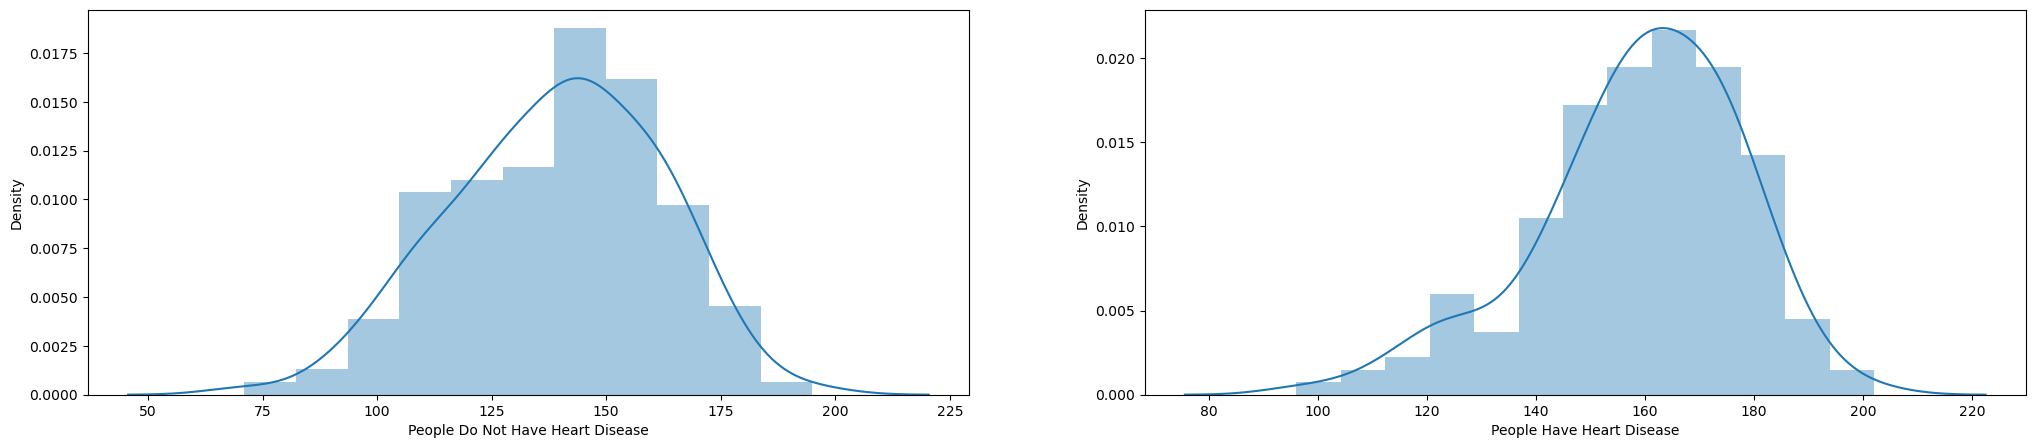

In [34]:
# Display maximum heart rate distribution based on heart disease
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(25, 5))
ax = sns.distplot(df[df['target'] == 0]['thalach'], label='Do not have heart disease', ax = axis1)
ax.set(xlabel = 'People Do Not Have Heart Disease')
ax = sns.distplot(df[df['target'] == 1]['thalach'], label = 'Have heart disease', ax = axis2)
ax.set(xlabel = 'People Have Heart Disease')
plt.show()

In [35]:
# Get min, max and average of the maximum heart rate of the people do not have heart diseas
print('Min resting blood pressure of people who do not have heart disease: ', min(df[df['target'] == 0]['thalach']))
print('Max resting blood pressure of people who do not have heart disease: ', max(df[df['target'] == 0]['thalach']))
print('Average resting blood pressure of people who do not have heart disease: ', df[df['target'] == 0]['thalach'].mean())

Min resting blood pressure of people who do not have heart disease:  71
Max resting blood pressure of people who do not have heart disease:  195
Average resting blood pressure of people who do not have heart disease:  138.97810218978103


In [36]:
# Get min, max and average of the maximum heart rate of the people have heart diseas
print('Min maximum heart rate  of people who have heart disease: ', min(df[df['target'] == 1]['thalach']))
print('Max maximum heart rate people who have heart disease: ', max(df[df['target'] == 1]['thalach']))
print('Average maximum heart rate of people who have heart disease: ', df[df['target'] == 1]['thalach'].mean())

Min maximum heart rate  of people who have heart disease:  96
Max maximum heart rate people who have heart disease:  202
Average maximum heart rate of people who have heart disease:  158.73170731707316


Exercise Induced Angina Exploration

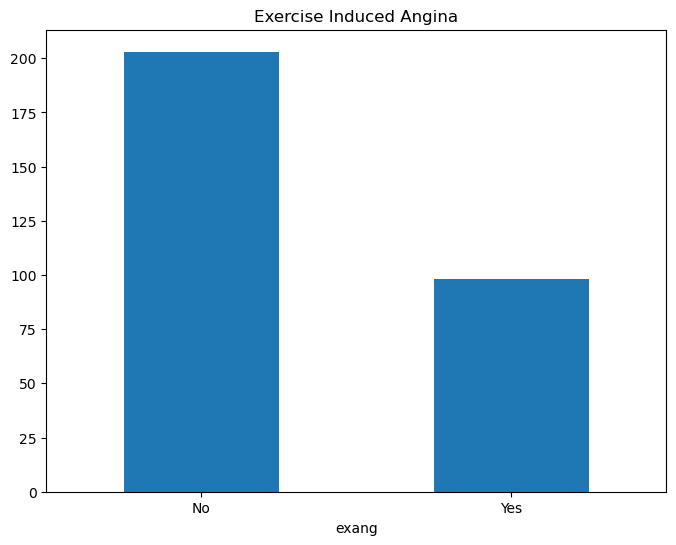

In [37]:
# Display exercise induced angina in bar chart
df.groupby(df['exang']).count()['target'].plot(kind = 'bar', title = 'Exercise Induced Angina',  figsize = (8, 6))
plt.xticks(np.arange(2), ('No', 'Yes'), rotation = 0)
plt.show()

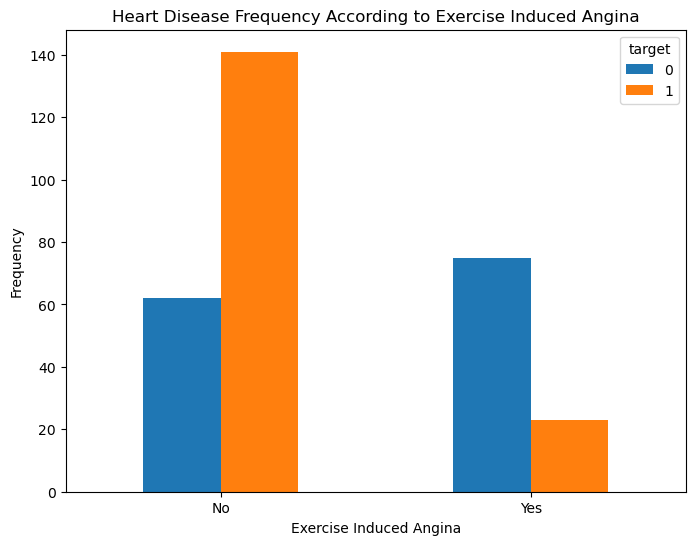

In [38]:
# Display exercise induced angina based on the target
pd.crosstab(df.exang,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Exercise Induced Angina')
plt.xlabel('Exercise Induced Angina')
plt.xticks(np.arange(2), ('No', 'Yes'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

ST depression Exploration

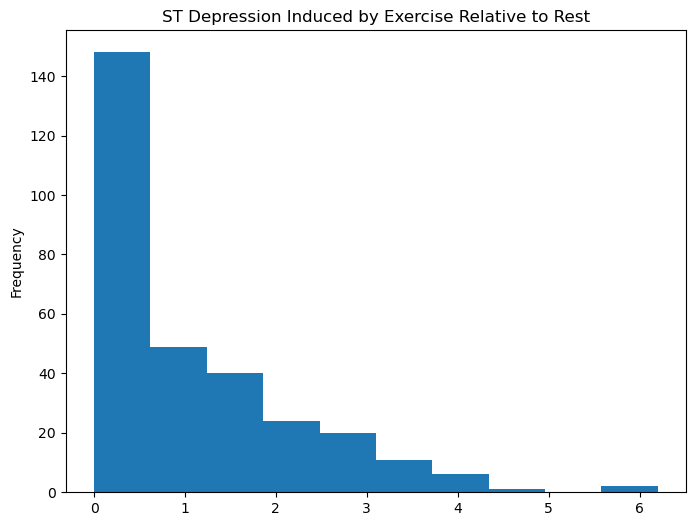

In [39]:
# Display ST depression induced by exercise relative to rest distribution
df['oldpeak'].plot(kind = 'hist', title = 'ST Depression Induced by Exercise Relative to Rest', figsize = (8, 6))
plt.show()

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/626705476.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/var/folders/v5/y_xt4kxn2z5fw15ml5lwy4sc0000gn/T/ipykernel_95328/626705476.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level 

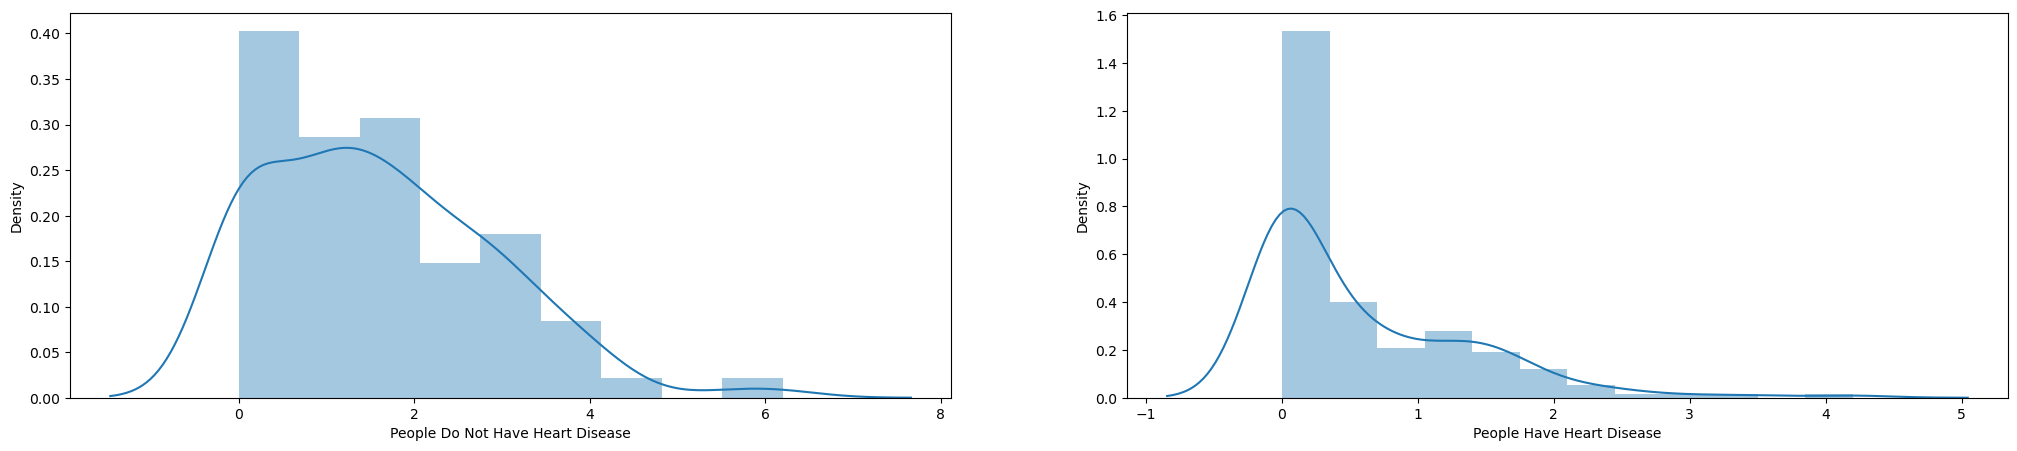

In [40]:
# Display ST depression distribution based on heart disease
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(25, 5))
ax = sns.distplot(df[df['target'] == 0]['oldpeak'], label='Do not have heart disease', ax = axis1)
ax.set(xlabel = 'People Do Not Have Heart Disease')
ax = sns.distplot(df[df['target'] == 1]['oldpeak'], label = 'Have heart disease', ax = axis2)
ax.set(xlabel = 'People Have Heart Disease')
plt.show()

In [41]:
# Get min, max and average of the ST depression  of the people have heart disease
print('Min ST depression of people who do not have heart disease: ', min(df[df['target'] == 0]['oldpeak']))
print('Max ST depression of people who do not have heart disease: ', max(df[df['target'] == 0]['oldpeak']))
print('Average ST depression of people who do not have heart disease: ', df[df['target'] == 0]['oldpeak'].mean())

Min ST depression of people who do not have heart disease:  0.0
Max ST depression of people who do not have heart disease:  6.2
Average ST depression of people who do not have heart disease:  1.5897810218978101


In [42]:
# Get min, max and average of the ST depression of the people have heart diseas
print('Min ST depression of people who have heart disease: ', min(df[df['target'] == 1]['oldpeak']))
print('Max ST depression of people who have heart disease: ', max(df[df['target'] == 1]['oldpeak']))
print('Average ST depression of people not have heart disease: ', df[df['target'] == 1]['oldpeak'].mean())

Min ST depression of people who have heart disease:  0.0
Max ST depression of people who have heart disease:  4.2
Average ST depression of people not have heart disease:  0.5865853658536585


Slope Exploration

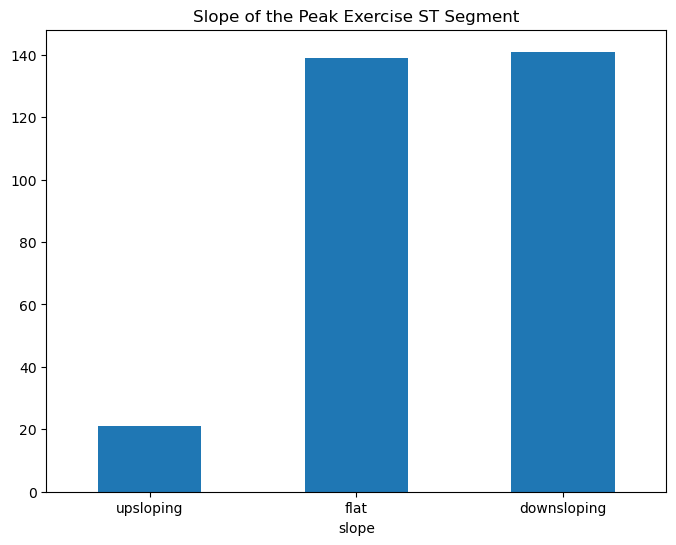

In [43]:
# Display slope of the peak exercise ST segment in bar chart
df.groupby(df['slope']).count()['target'].plot(kind = 'bar', title = 'Slope of the Peak Exercise ST Segment', figsize = (8, 6))
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation = 0)
plt.show()

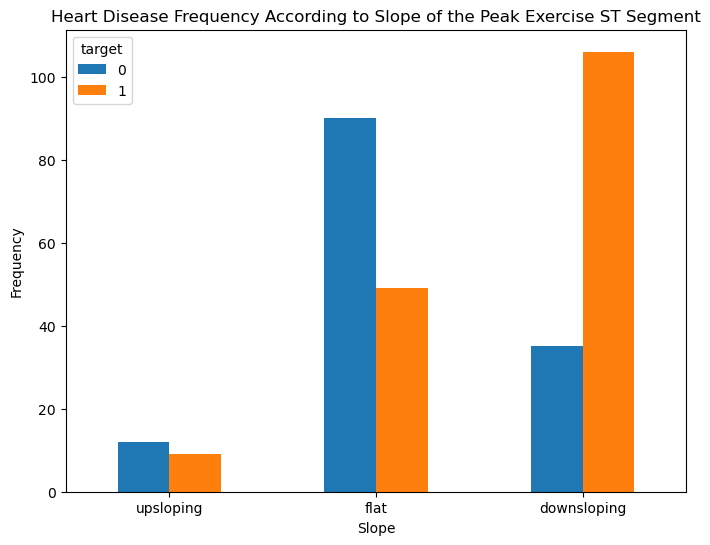

In [44]:
# Display slope of the peak exercise ST segment based on the target
pd.crosstab(df.slope,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Slope of the Peak Exercise ST Segment')
plt.xlabel('Slope')
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

Major Vessels Exploration

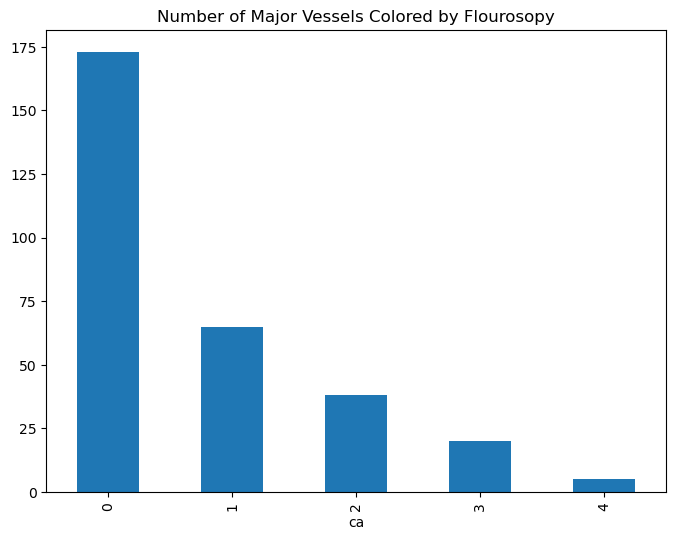

In [45]:
# Display number of major vessels in bar chart
df.groupby(df['ca']).count()['target'].plot(kind = 'bar', title = 'Number of Major Vessels Colored by Flourosopy',
                                            figsize = (8, 6))
plt.show()

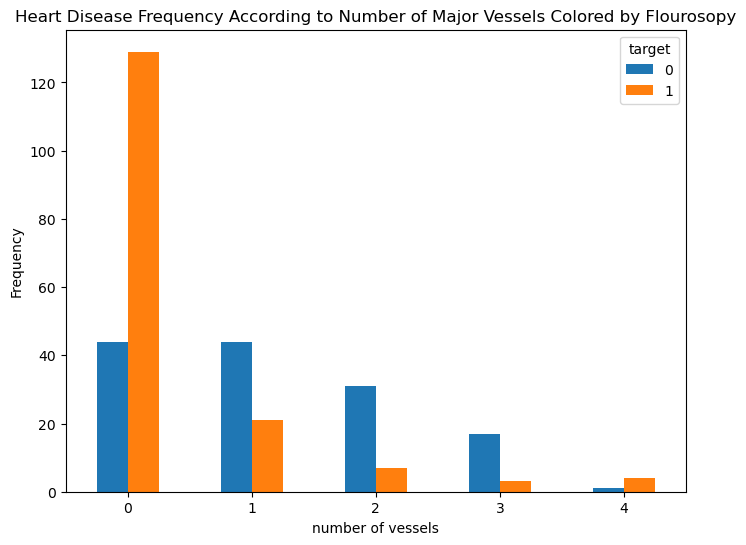

In [46]:
# Display number of vessels based on the target
pd.crosstab(df.ca,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Number of Major Vessels Colored by Flourosopy')
plt.xlabel('number of vessels')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

Thalassemia Exploration

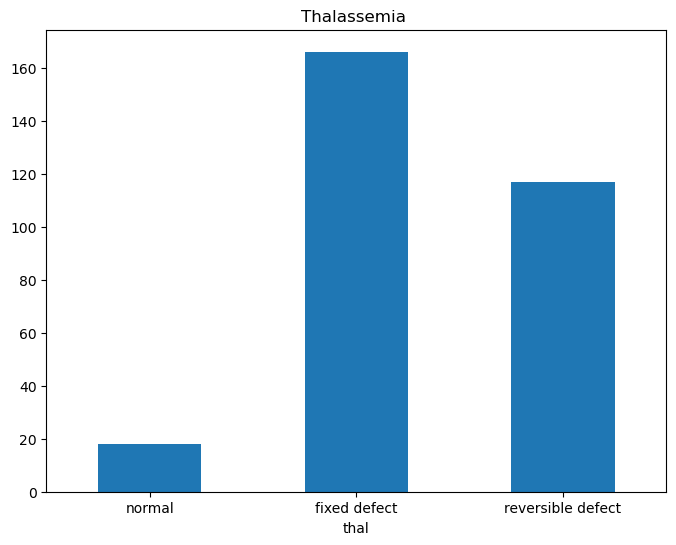

In [47]:
# Display thalassemia in bar chart

df.groupby(df['thal']).count()['target'].plot(kind = 'bar', title = 'Thalassemia ', figsize = (8, 6))
plt.xticks(np.arange(3), ('normal', 'fixed defect', 'reversible defect'), rotation=0)
plt.show()

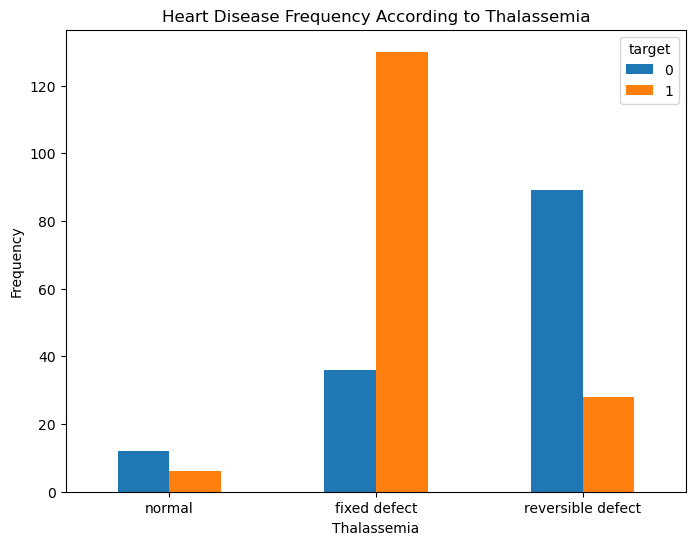

In [48]:
pd.crosstab(df.thal,df.target).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Thalassemia')
plt.xlabel('Thalassemia')
plt.xticks(np.arange(3), ('normal', 'fixed defect', 'reversible defect'), rotation = 0)
plt.ylabel('Frequency')
plt.show()

The correlation between oldpeak, slope and target

/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



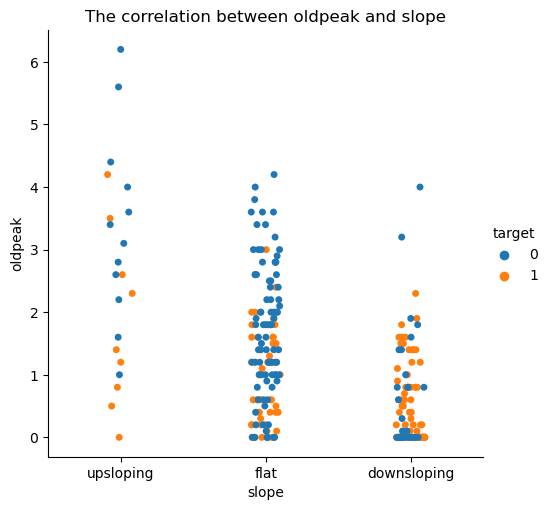

In [49]:
sns.catplot(x = "slope", y = "oldpeak", hue = "target", data = df)
plt.title('The correlation between oldpeak and slope')
plt.xticks(np.arange(3), ('upsloping', 'flat', 'downsloping'), rotation = 0)
plt.show()

The correlation between ca and age

/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



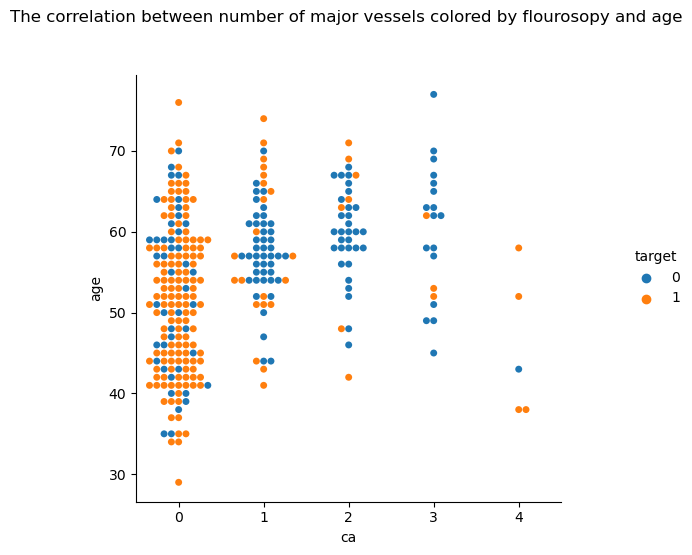

In [50]:
g = sns.catplot(x = 'ca', y = 'age', hue = 'target', data = df, kind="swarm")
g.fig.suptitle('The correlation between number of major vessels colored by flourosopy and age', y = 1.1)
plt.show()

The correlation between age and thalach

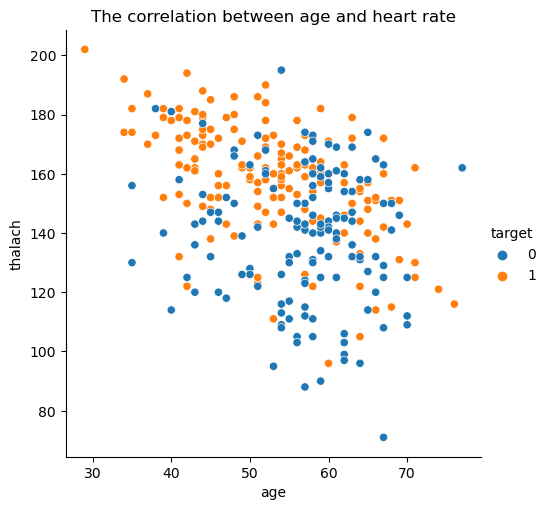

In [51]:
sns.relplot(x = 'age', y = 'thalach', data = df, hue = 'target', legend="full")
plt.title('The correlation between age and heart rate')
plt.show()

**Modeling**

Prepare Data for Machine Learning

In [52]:
# Initialize data and target
target = df['target']
features = df.drop(['target'], axis = 1)

In [53]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 0)

Train and Evaluate Models

Model Evaluation

In [54]:
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[44  2]
 [ 1 44]]


Accuracy of Logistic Regression: 96.7032967032967 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.96      0.98      0.97        45

    accuracy                           0.97        91
   macro avg       0.97      0.97      0.97        91
weighted avg       0.97      0.97      0.97        91



/Users/arvindprashanth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression: ROC AUC=0.997


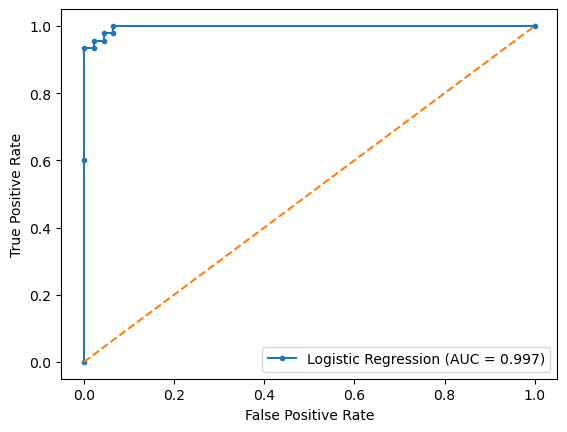

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

lr_probs = lr.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUC = %.3f)' % lr_auc)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()


In [56]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))

confussion matrix
[[44  2]
 [ 1 44]]


Accuracy of Naive Bayes model: 96.7032967032967 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.96      0.98      0.97        45

    accuracy                           0.97        91
   macro avg       0.97      0.97      0.97        91
weighted avg       0.97      0.97      0.97        91



Naive Bayes: ROC AUC=0.997


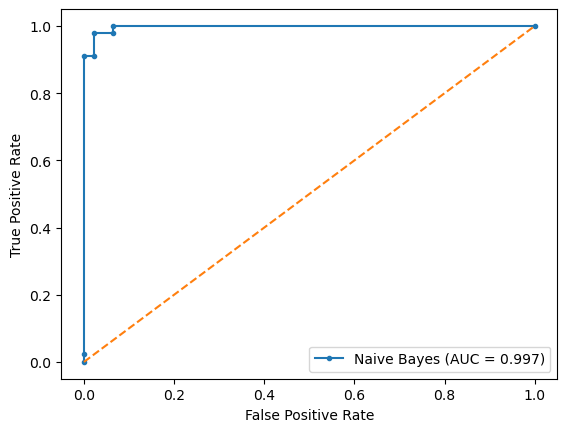

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

nb_probs = nb.predict_proba(X_test)
nb_probs = nb_probs[:, 1]

nb_auc = roc_auc_score(y_test, nb_probs)
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))

nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)

plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUC = %.3f)' % nb_auc)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

In [58]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=5,max_depth=1)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[45  1]
 [ 0 45]]


Accuracy of Random Forest: 98.9010989010989 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.98      1.00      0.99        45

    accuracy                           0.99        91
   macro avg       0.99      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91



Naive Bayes: ROC AUC=1.000


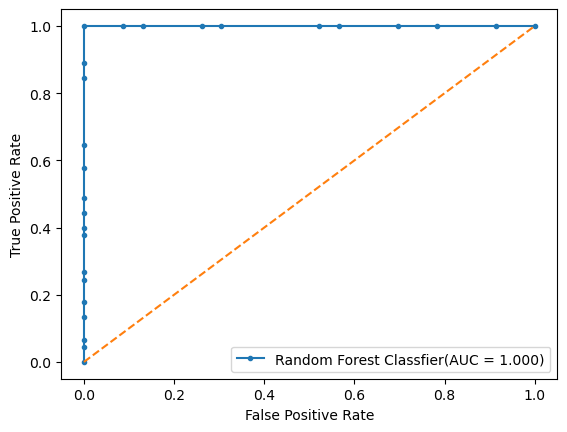

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

rf_probs = rf.predict_proba(X_test)
rf_probs = rf_probs[:, 1]

rf_auc = roc_auc_score(y_test, rf_probs)
print('Naive Bayes: ROC AUC=%.3f' % (rf_auc))

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest Classfier(AUC = %.3f)' % rf_auc)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

In [60]:
m4 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))

confussion matrix
[[46  0]
 [ 2 43]]


Accuracy of K-NeighborsClassifier: 97.8021978021978 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        46
           1       1.00      0.96      0.98        45

    accuracy                           0.98        91
   macro avg       0.98      0.98      0.98        91
weighted avg       0.98      0.98      0.98        91



Naive Bayes: ROC AUC=1.000


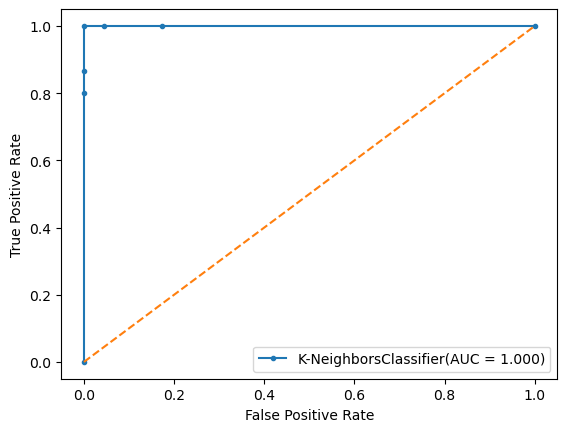

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

knn_probs = knn.predict_proba(X_test)
knn_probs = knn_probs[:, 1]

knn_auc = roc_auc_score(y_test, knn_probs)
print('Naive Bayes: ROC AUC=%.3f' % (knn_auc))

knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)

plt.plot(knn_fpr, knn_tpr, marker='.', label='K-NeighborsClassifier(AUC = %.3f)' % knn_auc)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()


In [62]:
m5 = 'Support Vector Classifier'
svc =  SVC(kernel='sigmoid', C=2)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print(classification_report(y_test,svc_predicted))

confussion matrix
[[27 19]
 [ 8 37]]


Accuracy of Support Vector Classifier: 70.32967032967034 

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        46
           1       0.66      0.82      0.73        45

    accuracy                           0.70        91
   macro avg       0.72      0.70      0.70        91
weighted avg       0.72      0.70      0.70        91



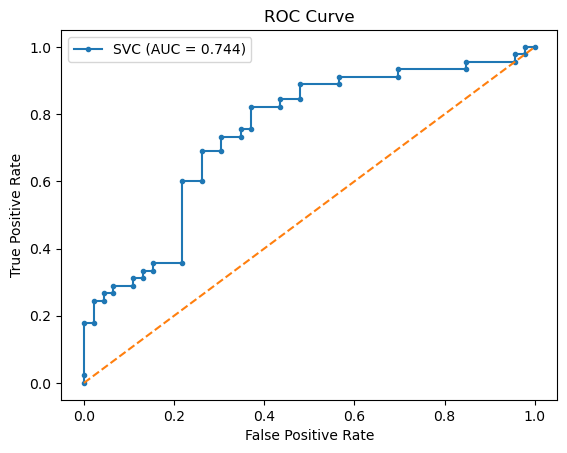

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

svc = SVC(kernel='sigmoid', C=2, probability=True)
svc.fit(X_train, y_train)
svc_probs = svc.predict_proba(X_test)[:, 1]

svc_auc = roc_auc_score(y_test, svc_probs)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)

plt.plot(svc_fpr, svc_tpr, marker='.', label='SVC (AUC = %.3f)' % svc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Model Selection

In [64]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Naive Bayes','Random Forest',
                    'K-Nearest Neighbour','Support Vector Machine'], 'Accuracy': [lr_acc_score*100,
                    nb_acc_score*100,rf_acc_score*100,knn_acc_score*100,svc_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,96.703297
1,Naive Bayes,96.703297
2,Random Forest,98.901099
3,K-Nearest Neighbour,97.802198
4,Support Vector Machine,70.329670


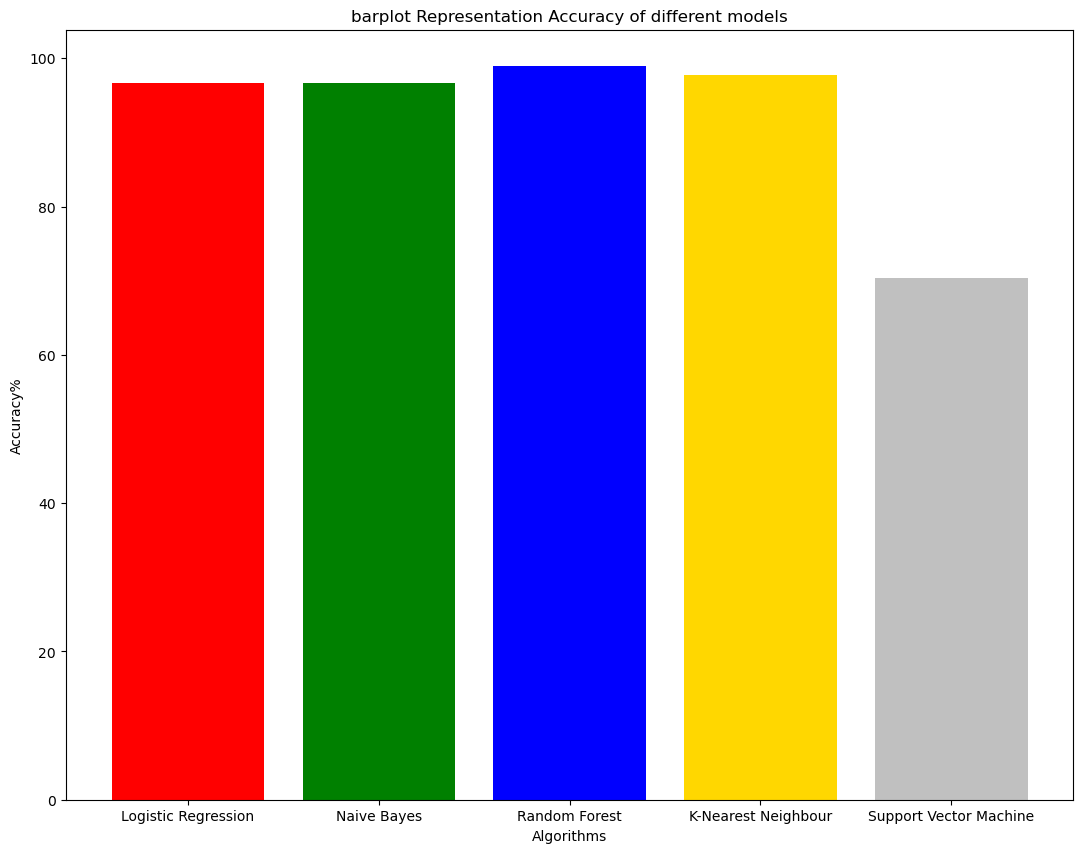

In [65]:
colors = ['red','green','blue','gold','silver']
plt.figure(figsize=(13,10))
plt.title("barplot Representation Accuracy of different models")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy%")
plt.bar(model_ev['Model'],model_ev['Accuracy'],color = colors)
plt.show()

Save Model

In [66]:
# Save the model as serialized object pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(rf, file)